# Check the Jupyter Notebook

In [1]:
import requests
print("Requests library version:", requests.__version__)
print("Environment setup successful!")

Requests library version: 2.32.3
Environment setup successful!


In [2]:
import io
import boto3
import matplotlib.pyplot as plt

import sys, os
import json
import requests
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Initialize boto3 client for S3
s3_client = boto3.client('s3', aws_access_key_id='', aws_secret_access_key='')


bucket_name = 'mys3repobucket'

In [3]:
def kelvin_to_fahrenheit(kelvin):
    fahrenheit = round((kelvin - 273.15) * 9/5 + 32, 1)
    return fahrenheit


# Function to save text to S3
def save_text_to_s3(text, bucket_name, file_name):
    
    try:
        # Upload text as a file to S3
        s3_client.put_object(Bucket=bucket_name, Key=file_name, Body=text)
        print(f"File '{file_name}' uploaded to bucket '{bucket_name}' successfully.")
    except (NoCredentialsError, PartialCredentialsError) as e:
        print("Credentials not available.", e)
    except Exception as e:
        print("Error uploading file:", e)

# Pulling the data

In [4]:
api_key = "9d509e6c1f583384313b9fa422a8d61c"
base_url = "http://api.openweathermap.org/data/2.5/forecast?"

lat = 30.2672
lon = -97.7431

complete_url = base_url + "appid=" + api_key + "&lat="+ str(lat) + "&lon=" + str(lon)
print(complete_url)

response = requests.get(complete_url)
data = response.json()
# print(data)

http://api.openweathermap.org/data/2.5/forecast?appid=9d509e6c1f583384313b9fa422a8d61c&lat=30.2672&lon=-97.7431
{'cod': '200', 'message': 0, 'cnt': 40, 'list': [{'dt': 1730440800, 'main': {'temp': 295.73, 'feels_like': 295.45, 'temp_min': 294.84, 'temp_max': 295.73, 'pressure': 1017, 'sea_level': 1017, 'grnd_level': 993, 'humidity': 54, 'temp_kf': 0.89}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'clouds': {'all': 2}, 'wind': {'speed': 3.24, 'deg': 34, 'gust': 7.66}, 'visibility': 10000, 'pop': 0.2, 'rain': {'3h': 0.3}, 'sys': {'pod': 'n'}, 'dt_txt': '2024-11-01 06:00:00'}, {'dt': 1730451600, 'main': {'temp': 294.48, 'feels_like': 293.97, 'temp_min': 293.64, 'temp_max': 294.48, 'pressure': 1017, 'sea_level': 1017, 'grnd_level': 992, 'humidity': 50, 'temp_kf': 0.84}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'clouds': {'all': 21}, 'wind': {'speed': 3.25, 'deg': 38, 'gust': 6.58}, 'visibility': 10000, 

In [5]:
# Extract the date and temperature data in a list
dates = []
temperatures = []
feels_like = []
humidity = []
pressure = []

for item in data["list"]:
    # Parse date-time string to datetime object
    date = datetime.strptime(item["dt_txt"], "%Y-%m-%d %H:%M:%S")
    temp = item["main"]["temp"] - 273.15  # Convert from Kelvin to Celsius
    feels = item["main"]["feels_like"] - 273.15  # Convert from Kelvin to Celsius
    humid = item["main"]["humidity"]
    press = item["main"]["pressure"]
    
    dates.append(date)
    temperatures.append(temp)
    feels_like.append(feels)
    humidity.append(humid)
    pressure.append(press)



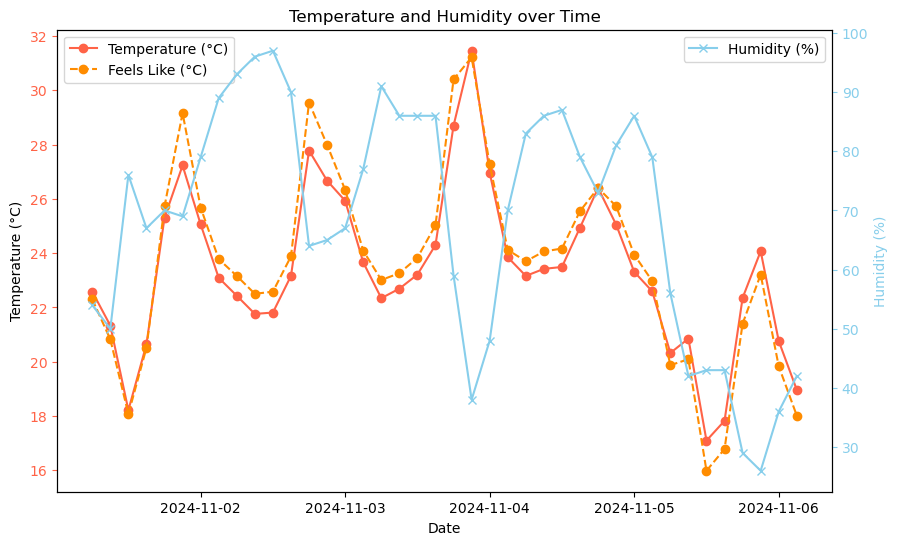

In [6]:
# creating I/O buffer for temporarily saving files
buffer = io.BytesIO()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Temperature and Feels Like Temperature on the primary y-axis
ax1.plot(dates, temperatures, label="Temperature (°C)", color="tomato", marker="o")
ax1.plot(dates, feels_like, label="Feels Like (°C)", color="darkorange", linestyle='--', marker="o")
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°C)")
ax1.legend(loc="upper left")
ax1.tick_params(axis="y", colors="tomato")

# Create a secondary y-axis for Humidity or Precipitation
ax2 = ax1.twinx()

# Uncomment either humidity or precipitation depending on preference
ax2.plot(dates, humidity, label="Humidity (%)", color="skyblue", marker="x")
# ax2.plot(data['Date'], data['Precipitation'], label="Precipitation (mm)", color="skyblue", marker="x")

# Setting y-axis for secondary data
ax2.set_ylabel("Humidity (%)", color="skyblue")  # Change to "Precipitation (mm)" if plotting precipitation
ax2.tick_params(axis="y", colors="skyblue")
ax2.legend(loc="upper right")

# Title and show plot
plt.title("Temperature and Humidity over Time")

# Save the figure to an in-memory buffer
plt.savefig(buffer, format='png')
buffer.seek(0)  # Reset the buffer position to the beginning


plt.show()

## Saving plot 1 to s3

In [7]:
object_name = 'weather_report/plot1.png'

s3_client.upload_fileobj(
    buffer,
    Bucket=bucket_name,
    Key=object_name,
    ExtraArgs={'ACL': 'public-read', 'ContentType': 'image/png'}
)

# Close the buffer
buffer.close()

# Convert the JSON file to Pandas dataframe

In [8]:
# Normalize the 'list' data
df = pd.json_normalize(data['list'])

df['dt_txt'] = pd.to_datetime(df['dt_txt'])  # Convert to datetime
# df.set_index('dt_txt', inplace=True)  # Set the datetime as the index

df["weather_desc"] = df["weather"].apply(lambda x:x[0].get('description'))

# Saving the DataFrame as a CSV file
df.to_csv('weather_data.csv', index=False)

# Display the DataFrame
pd.set_option('display.max_columns', 200)
print(df.head())

           dt                                            weather  visibility  \
0  1730440800  [{'id': 500, 'main': 'Rain', 'description': 'l...       10000   
1  1730451600  [{'id': 500, 'main': 'Rain', 'description': 'l...       10000   
2  1730462400  [{'id': 501, 'main': 'Rain', 'description': 'm...       10000   
3  1730473200  [{'id': 500, 'main': 'Rain', 'description': 'l...       10000   
4  1730484000  [{'id': 500, 'main': 'Rain', 'description': 'l...       10000   

    pop              dt_txt  main.temp  main.feels_like  main.temp_min  \
0  0.20 2024-11-01 06:00:00     295.73           295.45         294.84   
1  0.45 2024-11-01 09:00:00     294.48           293.97         293.64   
2  1.00 2024-11-01 12:00:00     291.36           291.22         291.36   
3  1.00 2024-11-01 15:00:00     293.79           293.66         293.79   
4  1.00 2024-11-01 18:00:00     298.46           298.87         298.46   

   main.temp_max  main.pressure  main.sea_level  main.grnd_level  \
0     

In [24]:
message_text = f"""
The weather forecast for {df.loc[0, "dt_txt"]} is {df.loc[0, "weather_desc"]} and {kelvin_to_fahrenheit(df.loc[0, "main.temp"])} (°F). Today, the temperature will range from {kelvin_to_fahrenheit(df.loc[0, "main.temp_min"])} to {kelvin_to_fahrenheit(df.loc[0, "main.temp_max"])} degrees (°F).

The wind speed will be between {min(df["wind.speed"])} and {max(df["wind.speed"])} meters/sec over this period.
"""

print(message_text)

file_name = "weather_report/weather_report_text.txt"
save_text_to_s3(message_text, bucket_name, file_name)


The weather forecast for 2024-11-01 06:00:00 is light rain and 72.6 (°F). Today, the temperature will range from 71.0 to 72.6 degrees (°F).

The wind speed will be between 1.36 and 8.16 meters/sec over this period.

File 'weather_report/weather_report_text.txt' uploaded to bucket 'mys3repobucket' successfully.


# Plot 2

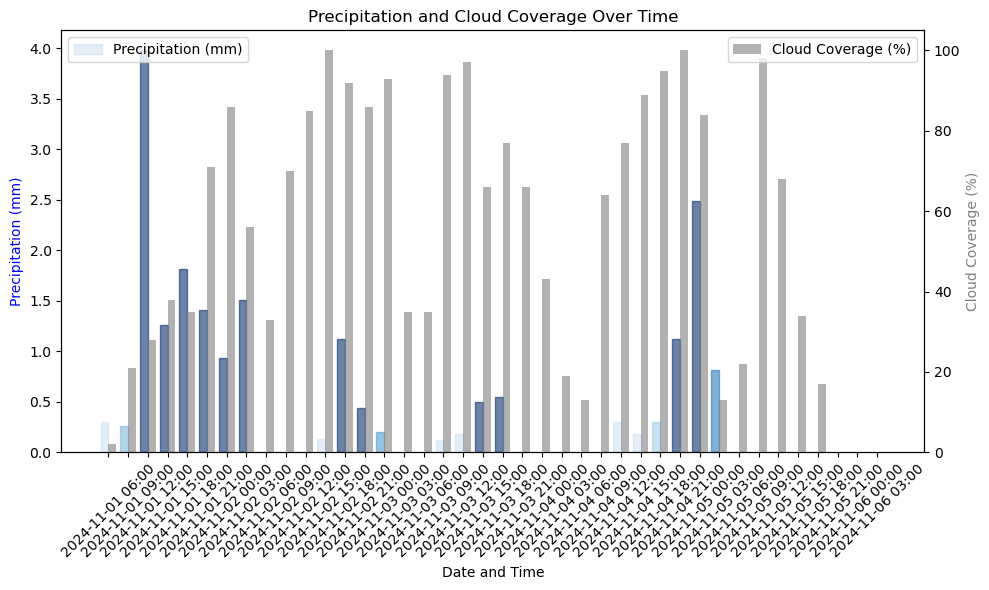

In [10]:
# creating I/O buffer for temporarily saving files
buffer = io.BytesIO()

# Set up the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar positions
bar_width = 0.4
x = np.arange(len(df))

# Create bars for precipitation
bars_precip = ax1.bar(x, df['rain.3h'], width=bar_width, label='Precipitation (mm)', color='blue', alpha=0.6)

# Create another y-axis for cloud coverage
ax2 = ax1.twinx()
bars_clouds = ax2.bar(x + bar_width, df['clouds.all'], width=bar_width, label='Cloud Coverage (%)', color='gray', alpha=0.6)

# Add color shading based on probability of precipitation (pop)
for bar, prob in zip(bars_precip, df['pop']):
    bar.set_color(plt.cm.Blues(prob))  # Use a colormap to set bar color based on 'pop'

# Labels and title
ax1.set_xlabel('Date and Time')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax2.set_ylabel('Cloud Coverage (%)', color='gray')
ax1.set_title('Precipitation and Cloud Coverage Over Time')
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(df['dt_txt'].dt.strftime('%Y-%m-%d %H:%M'), rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the figure to an in-memory buffer
plt.savefig(buffer, format='png')
buffer.seek(0)  # Reset the buffer position to the beginning

# Show plot
plt.tight_layout()
plt.show()


In [11]:
object_name = 'weather_report/plot2.png'

s3_client.upload_fileobj(
    buffer,
    Bucket=bucket_name,
    Key=object_name,
    ExtraArgs={'ACL': 'public-read', 'ContentType': 'image/png'}
)

# Close the buffer
buffer.close()